In [ ]:
import csv
import nest_asyncio

nest_asyncio.apply()

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
#from sklearn.externals import joblib
import joblib
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

from pytz import timezone; 

from numpy.random import seed
import tensorflow as tf

from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers

In [ ]:
seed(10)
tf.random.set_seed(10)

In [ ]:
dataset = 'full_capture20110818_preprocessed_rolling_10_per_cent_frame_delta_time_pre_attack_mean.csv'

In [ ]:
df = pd.read_csv (dataset, parse_dates=True, index_col='frame.time')
df.index = df.index.tz_convert(tz='Europe/Berlin')
df

,frame_len_skew,frame_len_kurt,frame_time_delta_skew,frame_time_delta_kurt,tcp_window_size_skew,tcp_window_size_kurt,Class
frame.time,,,,,,,
2011-08-18 10:19:13+02:00,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2011-08-18 10:19:14+02:00,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2011-08-18 10:19:15+02:00,0.819354,NaN,-1.465798,NaN,-0.372869,NaN,0.0
2011-08-18 10:19:16+02:00,0.947504,0.271008,-1.754291,3.042090,1.494747,2.486826,0.0
2011-08-18 10:19:17+02:00,1.256111,0.932081,-0.590716,-2.786635,0.353852,-2.798971,0.0
...,...,...,...,...,...,...,...
2011-08-18 11:52:49+02:00,-2.662761,14.734984,0.205026,1.324001,0.019434,-0.709804,1.0
2011-08-18 11:52:50+02:00,-2.651266,14.655029,0.205390,1.291960,0.040859,-0.679819,1.0
2011-08-18 11:52:51+02:00,-2.647468,14.623319,0.210574,1.297850,0.034215,-0.686379,0.0


In [ ]:
df.dropna(inplace=True)
print(df.isnull().sum())
#df.info()

frame_len_skew           0
frame_len_kurt           0
frame_time_delta_skew    0
frame_time_delta_kurt    0
tcp_window_size_skew     0
tcp_window_size_kurt     0
Class                    0
dtype: int64


In [ ]:
new_df = df.drop(columns=['Class'])
#new_df = new_df[:'2011-08-18 11:52:53']
new_df.shape

(5582, 6)

In [ ]:
import matplotlib.pyplot as plt

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 15

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rcParams["date.autoformatter.minute"] = "%H:%M"

[Text(0, 0.5, 'Skewness'), Text(0.5, 0, 'Tempo')]

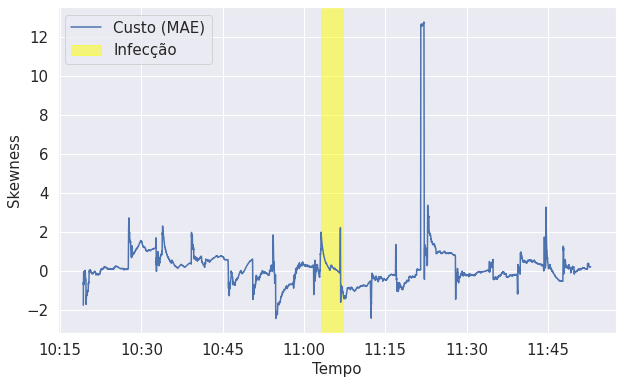

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams['timezone'] = 'Europe/Berlin'

fig, axs = plt.subplots(1, 1, figsize=(10, 6))

axs.plot(df['frame_time_delta_skew'])
axs.axvspan(pd.to_datetime('2011-08-18 11:03:05').tz_localize('Europe/Berlin'), pd.to_datetime('2011-08-18 11:07:15').tz_localize('Europe/Berlin'), color='yellow', alpha=0.5, label='Infecção')
labels = ['Custo (MAE)', 'Infecção']
axs.legend(loc="upper left", labels=labels)
axs.set(xlabel='Tempo', ylabel='Skewness')

[Text(0, 0.5, 'Kurtosis'), Text(0.5, 0, 'Tempo')]

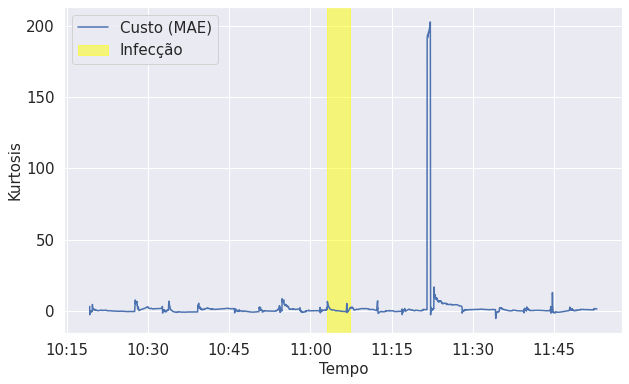

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 1, figsize=(10, 6))

axs.plot(df['frame_time_delta_kurt'])
axs.axvspan(pd.to_datetime('2011-08-18 11:03:05').tz_localize('Europe/Berlin'), pd.to_datetime('2011-08-18 11:07:15').tz_localize('Europe/Berlin'), color='yellow', alpha=0.5, label='Infecção')
labels = ['Custo (MAE)', 'Infecção']
axs.legend(loc="upper left", labels=labels)
axs.set(xlabel='Tempo', ylabel='Kurtosis')

In [ ]:
total_rows = 5638
train_chunk = round(total_rows / 3)
test_chunk_1 = train_chunk * 2

In [ ]:
train = new_df.iloc[:train_chunk]
test = new_df.iloc[train_chunk:test_chunk_1]
test_2 = new_df.iloc[test_chunk_1:]
print("Training dataset shape: ", train.shape)
print("Validation dataset shape: ", test.shape)
print("Test dataset shape: ", test_2.shape)

Training dataset shape:  (1879, 6)
Validation dataset shape:  (1879, 6)
Test dataset shape:  (1824, 6)


In [ ]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train)
X_test = scaler.fit_transform(test)
X_test_2 = scaler.fit_transform(test_2)
scaler_filename = 'scaler_data'
joblib.dump(scaler, scaler_filename)

['scaler_data']

In [ ]:
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print("Training data shape:", X_train.shape)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print("Test data shape: ", X_test.shape)
X_test_2 = X_test_2.reshape(X_test_2.shape[0], 1, X_test_2.shape[1])
print("Test data shape: ", X_test_2.shape)

Training data shape: (1879, 1, 6)
Test data shape:  (1879, 1, 6)
Test data shape:  (1824, 1, 6)


In [ ]:
def autoencoder_model(X):
  inputs = Input(shape=(X.shape[1], X.shape[2]))
  L1 = LSTM(16, activation='relu', return_sequences=True, kernel_regularizer=regularizers.l2(0.00))(inputs)
#  L1 = LSTM(16, activation='relu', return_sequences=True)(inputs)  
  L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
  L3 = RepeatVector(X.shape[1])(L2)
  L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
  L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
  output = TimeDistributed(Dense(X.shape[2]))(L5)
  model = Model(inputs=inputs, outputs=output)
  return model 

In [ ]:
X_train

array([[[0.84491144, 0.23434161, 0.        , 0.56498148, 0.73076163,
         0.472048  ]],

       [[0.91554759, 0.29694241, 0.26015206, 0.        , 0.40654159,
         0.06748032]],

       [[0.97619224, 0.39933467, 0.23622573, 0.19328753, 0.49724811,
         0.1554272 ]],

       ...,

       [[0.78278125, 0.24053622, 0.18790617, 0.37873222, 0.4272021 ,
         0.16059786]],

       [[0.73553052, 0.2031405 , 0.16291973, 0.39232007, 0.46458564,
         0.17147679]],

       [[0.73291424, 0.22265041, 0.14377496, 0.42477504, 0.44368857,
         0.19063104]]])

In [ ]:
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 6)]            0         
                                                                 
 lstm (LSTM)                 (None, 1, 16)             1472      
                                                                 
 lstm_1 (LSTM)               (None, 4)                 336       
                                                                 
 repeat_vector (RepeatVector  (None, 1, 4)             0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 1, 4)              144       
                                                                 
 lstm_3 (LSTM)               (None, 1, 16)             1344      
                                                             

In [ ]:
print(X_train.shape)

(1879, 1, 6)


In [ ]:
nb_epochs = 100
batch_size = 10
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size, validation_split=0.10).history

Epoch 1/100
170/170 [==============================] - 7s 10ms/step - loss: 0.3258 - val_loss: 0.1397
Epoch 2/100
170/170 [==============================] - 1s 6ms/step - loss: 0.1180 - val_loss: 0.0986
Epoch 3/100
170/170 [==============================] - 1s 6ms/step - loss: 0.1125 - val_loss: 0.0925
Epoch 4/100
170/170 [==============================] - 1s 5ms/step - loss: 0.1106 - val_loss: 0.0917
Epoch 5/100
170/170 [==============================] - 1s 6ms/step - loss: 0.1082 - val_loss: 0.0867
Epoch 6/100
170/170 [==============================] - 1s 5ms/step - loss: 0.1049 - val_loss: 0.0831
Epoch 7/100
170/170 [==============================] - 1s 5ms/step - loss: 0.1012 - val_loss: 0.0858
Epoch 8/100
170/170 [==============================] - 1s 6ms/step - loss: 0.0982 - val_loss: 0.0895
Epoch 9/100
170/170 [==============================] - 1s 6ms/step - loss: 0.0959 - val_loss: 0.0919
Epoch 10/100
170/170 [==============================] - 1s 6ms/step - loss: 0.0943 - val_l

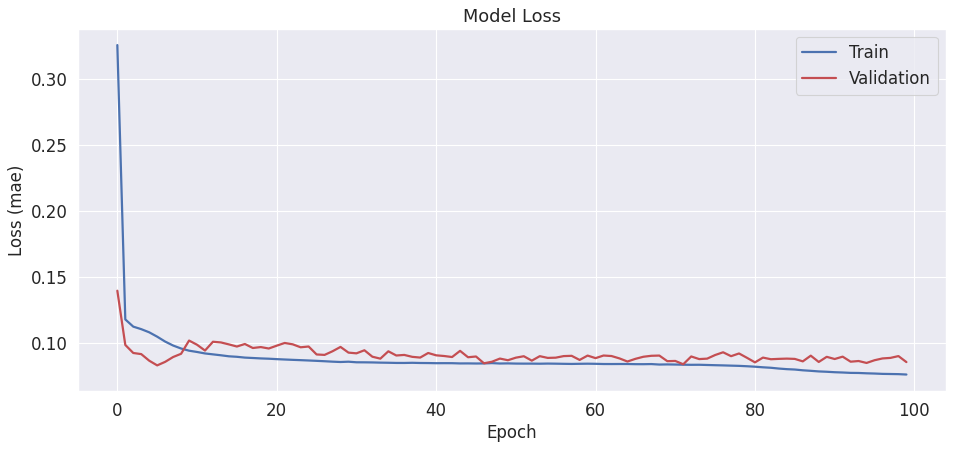

In [ ]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model Loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

In [ ]:
X_pred_train = model.predict(X_train)
X_pred_train = X_pred_train.reshape(X_pred_train.shape[0], X_train.shape[2])
X_pred_train = pd.DataFrame(X_pred_train, columns=train.columns)
X_pred_train.index = train.index.tz_convert('Europe/Berlin')
X_pred_train

,frame_len_skew,frame_len_kurt,frame_time_delta_skew,frame_time_delta_kurt,tcp_window_size_skew,tcp_window_size_kurt
frame.time,,,,,,
2011-08-18 10:19:16+02:00,0.616527,0.358632,0.449679,0.240652,0.580146,0.422591
2011-08-18 10:19:17+02:00,0.719251,0.378198,0.516359,0.376563,0.422557,0.298355
2011-08-18 10:19:18+02:00,0.720042,0.378358,0.516871,0.377622,0.421359,0.297418
2011-08-18 10:19:19+02:00,0.716885,0.377719,0.514831,0.373398,0.426140,0.301157
2011-08-18 10:19:20+02:00,0.747266,0.383957,0.534414,0.414111,0.380341,0.265434
...,...,...,...,...,...,...
2011-08-18 10:50:40+02:00,0.740466,0.382543,0.530040,0.404986,0.390552,0.273381
2011-08-18 10:50:41+02:00,0.732209,0.380840,0.524721,0.393914,0.402983,0.283069
2011-08-18 10:50:42+02:00,0.729754,0.380337,0.523138,0.390625,0.406685,0.285957


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Density')

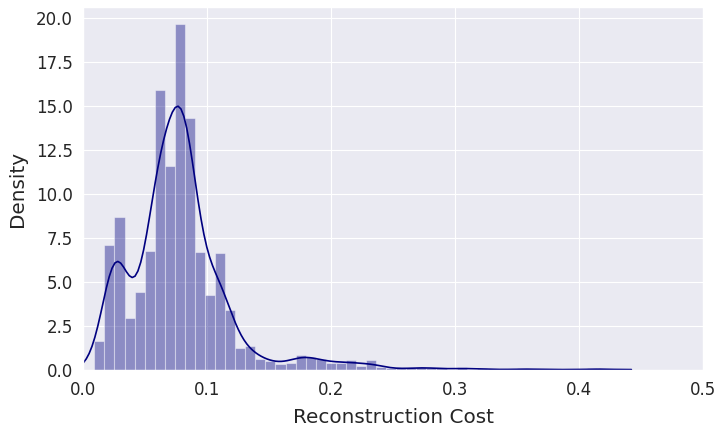

In [ ]:
X_pred_train = model.predict(X_train)
X_pred_train = X_pred_train.reshape(X_pred_train.shape[0], X_train.shape[2])
X_pred_train = pd.DataFrame(X_pred_train, columns=train.columns)
X_pred_train.index = train.index

scored_train = pd.DataFrame(index=train.index.tz_convert('Europe/Berlin'))
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-Xtrain), axis = 1)
plt.figure(figsize=(10,6), dpi=80)
#plt.title('Distribuição do Custo de Reconstrução', fontsize=22)
sns.distplot(scored_train['Loss_mae'], bins = 50, kde=True, color = 'navy');
sns.set(font_scale=1.4)
plt.xlim([0.0,.5])
plt.xlabel("Reconstruction Cost", fontsize=18, labelpad=8.0)
plt.ylabel("Density", fontsize=18, labelpad=8.0)

In [ ]:
X_test_full = np.concatenate((X_test, X_test_2), axis=0)
test_full = pd.concat([test, test_2])

In [ ]:
X_pred_test_full = model.predict(X_test_full)
X_pred_test_full = X_pred_test_full.reshape(X_pred_test_full.shape[0], X_pred_test_full.shape[2])
X_pred_test_full = pd.DataFrame(X_pred_test_full, columns=test_full.columns)
X_pred_test_full.index = test_full.index

scored_test_full = pd.DataFrame(index=test_full.index)
Xtest_full = X_test_full.reshape(X_test_full.shape[0], X_test_full.shape[2])

In [ ]:
scored_test_full['Loss_mae'] = np.mean(np.abs(X_pred_test_full-Xtest_full), axis = 1)
scored_test_full['Threshold'] = 0.35
scored_test_full['Anomaly'] = scored_test_full['Loss_mae'] > scored_test_full['Threshold']
scored_test_full.tail()

,Loss_mae,Threshold,Anomaly
frame.time,,,
2011-08-18 11:52:49+02:00,0.195081,0.35,False
2011-08-18 11:52:50+02:00,0.193532,0.35,False
2011-08-18 11:52:51+02:00,0.193343,0.35,False
2011-08-18 11:52:52+02:00,0.193550,0.35,False
2011-08-18 11:52:53+02:00,0.193628,0.35,False


In [ ]:
data_label = pd.DataFrame()
data_label['label'] = df['Class']
data_label['label'] = data_label['label'].astype(int)
data_label['label'].value_counts()
data_label = data_label[train_chunk:]

In [ ]:
concatenated = scored_test_full
concatenated['label'] = data_label['label']

In [ ]:
mae = pd.DataFrame()
mae['mae_anomaly'] = np.where(concatenated['label'] == 1, concatenated['Loss_mae'], 0)
mae['mae_anomaly']

In [ ]:
import matplotlib.pyplot as plt

SMALL_SIZE = 20
MEDIUM_SIZE = 15
BIGGER_SIZE = 15

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rcParams["date.autoformatter.minute"] = "%H:%M"

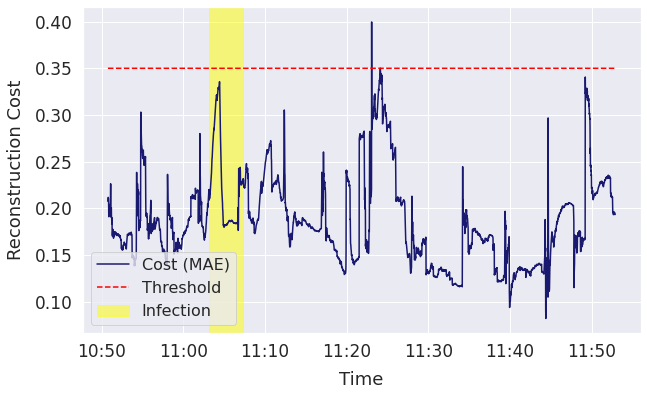

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
	label.set_fontsize(17)

ax.plot(concatenated['Loss_mae'], label='Cost (MAE)', color='midnightblue')
ax.plot(concatenated['Threshold'], label='Threshold', color = 'red', linestyle='dashed')

plt.axvspan(pd.to_datetime('2011-08-18 11:03:05').tz_localize('Europe/Berlin'), pd.to_datetime('2011-08-18 11:07:15').tz_localize('Europe/Berlin'), color='yellow', alpha=0.5, label='Infection')
plt.xlabel("Time", fontsize=18, labelpad=10.0)
plt.ylabel("Reconstruction Cost", fontsize=18, labelpad=10.0)
leg = ax.legend(prop={"size":16}, loc='lower left')

In [ ]:
ews_scored = concatenated['2011-08-18 11:03:05':]

In [ ]:
concatenated[concatenated['Anomaly']==True]

,Loss_mae,Threshold,Anomaly,label
frame.time,,,,
2011-08-18 11:23:03+02:00,0.399609,0.35,True,1
2011-08-18 11:24:07+02:00,0.350196,0.35,True,0


[Text(21.499999999999993, 0.5, 'Valor Previsto'), Text(0.5, 3.5, 'Valor Real')]

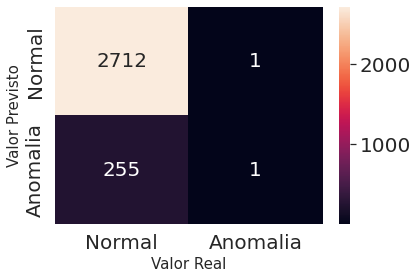

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

xticklabels=['Normal', 'Anomalia'] 
yticklabels=['Normal', 'Anomalia']
cm = confusion_matrix(ews_scored['label'], ews_scored['Anomaly'])
s = sns.heatmap(cm, annot=True, fmt='d', xticklabels=xticklabels, yticklabels=yticklabels)
s.set(xlabel='Valor Real', ylabel='Valor Previsto')

In [ ]:
tn, fp, fn, tp = confusion_matrix(ews_scored['label'], ews_scored['Anomaly']).ravel()

accuracy = (tn + tp) / (tn + fp + fn + tp)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

print(f'F1 Score = {round(f1_score, 2)}')
print(f'Accuracy = {round(accuracy, 2)}')
print(f'Precision = {round(precision, 2)}')
print(f'Recall = {round(recall, 3)}')

F1 Score = 0.01
Accuracy = 0.91
Precision = 0.5
Recall = 0.004
